# Model GLM2 ROI Analysis

### Model Comprehensive -- looks at fixed and conditional (correct vs. incorrect)

In [1]:
from os.path import join
from glob import glob
from scipy import stats
from scipy.stats import pearsonr
from pylab import *
from math import sqrt
import nibabel as nb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("white")
sns.set_palette('muted')

subs = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006', 
        'WMAZE_007', 'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012', 
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021',  
        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']

proj_dir = '/home/data/madlab/data/mri/wmaze'
 
mask_files = []
cope_files = []

for sub in subs:
    masks_glob = glob(proj_dir + '/roi_analysis/MRthesis/fb4c_2/mask/anat_masks/_subject_id_' 
                      + sub + '/_anatmask_xfm*/*')
    mask_files.append(sorted(masks_glob))
    copes_glob = glob(proj_dir + '/scndlvl/model_GLM2/' + sub + '/fixedfx/cope_*')
    cope_files.append(sorted(copes_glob))
    if len(cope_files[-1]) == 0:
        print(sub)

## Cell to double-check the array indexing

In [2]:
#change first index of cope_files to indicate participant index in subs array
for i, curr_mask in enumerate(mask_files[0]):
    print(i, mask_files[0][i].split('/')[-1][:-7]) 

(0, 'lh-all_mPFC_warped')
(1, 'lh-dmPFC_warped')
(2, 'lh-hippocampus_warped')
(3, 'lh-mPFC_fs-3reg_warped')
(4, 'lh-mPFC_fs_warped')
(5, 'lh-mPFC_lausanne_warped')
(6, 'lh-motor_warped')
(7, 'lh_caudate_anat_mask_warped')
(8, 'rh_caudate_anat_mask_warped')
(9, 'rh-all_mPFC_warped')
(10, 'rh-dmPFC_warped')
(11, 'rh-hippocampus_warped')
(12, 'rh-mPFC_fs-3reg_warped')
(13, 'rh-mPFC_fs_warped')
(14, 'rh-mPFC_lausanne_warped')
(15, 'rh-motor_warped')
(16, 'lh-putamen_warped')
(17, 'rh-putamen_warped')


In [3]:
for i, curr_cope in enumerate(cope_files[0]):
    print(i, cope_files[0][i].split('/')[-1][5:-7]) 

(0, 'AllVsBase')
(1, 'allCond_minus_allFixed')
(2, 'allCorr_minus_allIncorr')
(3, 'allFixed_minus_allCond')
(4, 'allIncorr_minus_allCorr')
(5, 'all_BL')
(6, 'all_cond')
(7, 'all_corr')
(8, 'all_fixed')
(9, 'all_incorr')
(10, 'condCorr_minus_condIncorr')
(11, 'condCorr_minus_fixedCorr')
(12, 'condIncorr_minus_condCorr')
(13, 'condIncorr_minus_fixedIncorr')
(14, 'cond_corr')
(15, 'cond_incorr')
(16, 'fixedCorr_minus_condCorr')
(17, 'fixedCorr_minus_fixedIncorr')
(18, 'fixedIncorr_minus_condIncorr')
(19, 'fixedIncorr_minus_fixedCorr')
(20, 'fixed_corr')
(21, 'fixed_incorr')


### Use binarized mask to obtain activation in left & right hemisphere for each region of interest

In [6]:
all_data = {'subjid':[],
            'lhhp_fixed_corr':[],'rhhp_fixed_corr':[],'lhhp_fixed_incorr':[],'rhhp_fixed_incorr':[],
            'lhhp_cond_corr':[],'rhhp_cond_corr':[],'lhhp_cond_incorr':[],'rhhp_cond_incorr':[],           
            'lhcaud_fixed_corr':[],'rhcaud_fixed_corr':[],'lhcaud_fixed_incorr':[],'rhcaud_fixed_incorr':[],
            'lhcaud_cond_corr':[],'rhcaud_cond_corr':[],'lhcaud_cond_incorr':[],'rhcaud_cond_incorr':[],           
            'lhput_fixed_corr':[],'rhput_fixed_corr':[],'lhput_fixed_incorr':[],'rhput_fixed_incorr':[],
            'lhput_cond_corr':[],'rhput_cond_corr':[],'lhput_cond_incorr':[], 'rhput_cond_incorr':[],
            'lhmpfc_fixed_corr':[],'rhmpfc_fixed_corr':[],'lhmpfc_fixed_incorr':[],'rhmpfc_fixed_incorr':[],
            'lhmpfc_cond_corr':[],'rhmpfc_cond_corr':[],'lhmpfc_cond_incorr':[],'rhmpfc_cond_incorr':[]}

for i in range(len(subs)):
    all_data['subjid'].append(subs[i])
    lh_hp_img = nb.load(mask_files[i][2])
    rh_hp_img = nb.load(mask_files[i][11])
    lh_mpfc_img = nb.load(mask_files[i][4])
    rh_mpfc_img = nb.load(mask_files[i][13])
    lh_caud_img = nb.load(mask_files[i][7])
    rh_caud_img = nb.load(mask_files[i][8])
    lh_put_img = nb.load(mask_files[i][16])
    rh_put_img = nb.load(mask_files[i][17])
    
    fixed_corr_img = nb.load(cope_files[i][20])
    fixed_incorr_img = nb.load(cope_files[i][21])
    cond_corr_img = nb.load(cope_files[i][14])
    cond_incorr_img = nb.load(cope_files[i][15]) 
    
    region = ['hp', 'mpfc', 'caud', 'put']
    trial_type = ['fixed_corr', 'fixed_incorr', 'cond_corr','cond_incorr']   
    for r in region:
        for t in trial_type:
            lh_data = eval('{0}_img.get_data()[lh_{1}_img.get_data() > 0.]'.format(t,r))
            all_data['lh{0}_{1}'.format(r,t)].append(np.mean(lh_data)) 
            rh_data = eval('{0}_img.get_data()[rh_{1}_img.get_data() > 0.]'.format(t,r))
            all_data['rh{0}_{1}'.format(r,t)].append(np.mean(rh_data))
    
all_data_df = pd.DataFrame(all_data)

### Combine the two hemispheres to create one regional average

In [7]:
region = ['hp', 'mpfc', 'caud', 'put']
trial_type = ['fixed_corr', 'fixed_incorr', 'cond_corr','cond_incorr'] 
for r in region:
    for t in trial_type:
        all_data_df['{0}_{1}'.format(r,t)] = (all_data_df['lh{0}_{1}'.format(r,t)] 
                                              + all_data_df['rh{0}_{1}'.format(r,t)])/2.

### Region-specific dataframes for producing plots

In [8]:
hp_plot = {}
mpfc_plot = {}
caud_plot = {}
put_plot = {}

for i in ['hp', 'mpfc', 'caud', 'put']:
    exec('{0}_plot["fixed_corr"] = all_data_df["{0}_fixed_corr"]'.format(i))
    exec('{0}_plot["fixed_incorr"] = all_data_df["{0}_fixed_incorr"]'.format(i))
    exec('{0}_plot["cond_corr"] = all_data_df["{0}_cond_corr"]'.format(i))
    exec('{0}_plot["cond_incorr"] = all_data_df["{0}_cond_incorr"]'.format(i))
    exec('{0}_plot_df = pd.DataFrame.from_dict({0}_plot)'.format(i))

## Hippocampus

Mean fixed_corr:  -1.1853275755
STD fixed_corr:  1.93649106968

Mean fixed_incorr:  -2.01949017271
STD fixed_incorr:  2.33335689691

Mean cond_corr:  -1.84878934985
STD cond_corr:  2.09212881048

Mean cond_incorr:  -3.54961400479
STD cond_incorr:  2.02337642369



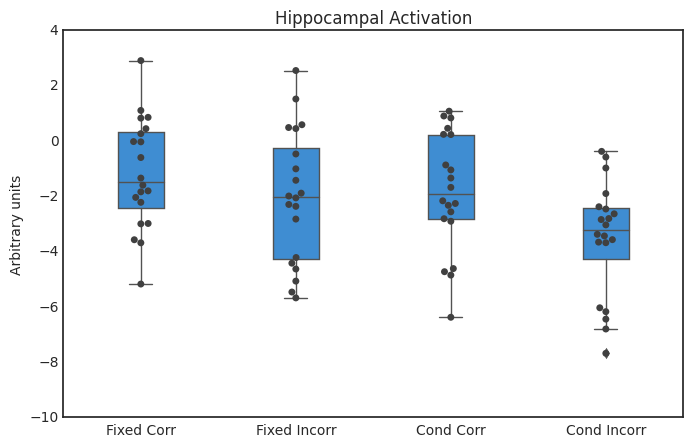

In [14]:
for key in hp_plot:
    print "Mean {0}: ".format(key), np.mean(hp_plot_df['{0}'.format(key)])
    print "STD {0}: ".format(key), np.std(hp_plot_df['{0}'.format(key)])
    print ""

N = 4
ind = np.arange(N)
conditions = ['Fixed Corr', 'Fixed Incorr', 'Cond Corr', 'Cond Incorr']
hp_allsubjs = [hp_plot_df['fixed_corr'], hp_plot_df['fixed_incorr'], 
               hp_plot_df['cond_corr'], hp_plot_df['cond_incorr']]
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.boxplot(data = hp_allsubjs, color = "#278fea", width = 0.3)
ax = sns.swarmplot(data = hp_allsubjs, color='.25')
ax.set_xticklabels(conditions)
ax.set_xticks(ind)
ax.set_ylabel("Arbitrary units")
ax.set_title("Hippocampal Activation")
plt.show()

## mPFC

Mean fixed_corr:  -2.19772249684
STD fixed_corr:  2.87369826428

Mean fixed_incorr:  0.233567442745
STD fixed_incorr:  4.31461045246

Mean cond_corr:  -2.46613665409
STD cond_corr:  3.01764448369

Mean cond_incorr:  -2.75842710529
STD cond_incorr:  2.61804725165



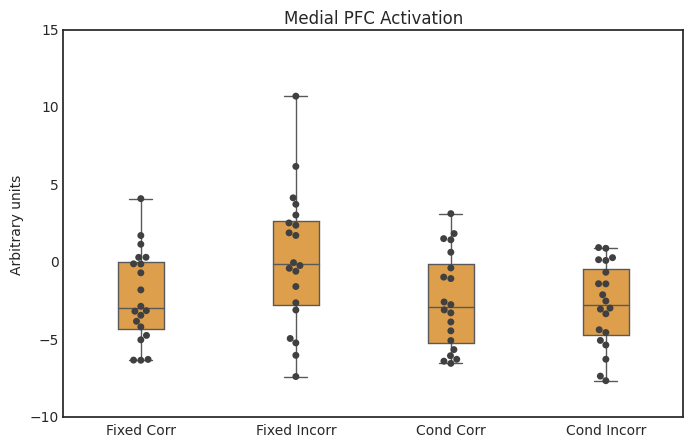

In [19]:
for key in mpfc_plot:
    print "Mean {0}: ".format(key), np.mean(mpfc_plot_df['{0}'.format(key)])
    print "STD {0}: ".format(key), np.std(mpfc_plot_df['{0}'.format(key)])
    print ""

N = 4
ind = np.arange(N)
conditions = ['Fixed Corr', 'Fixed Incorr', 'Cond Corr', 'Cond Incorr']
mpfc_allsubjs = [mpfc_plot_df['fixed_corr'], mpfc_plot_df['fixed_incorr'], 
                 mpfc_plot_df['cond_corr'], mpfc_plot_df['cond_incorr']]
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.boxplot(data = mpfc_allsubjs, color = "#f7a233", width = 0.3)
ax = sns.swarmplot(data = mpfc_allsubjs, color='.25')
ax.set_xticklabels(conditions)
ax.set_xticks(ind)
ax.set_ylabel("Arbitrary units")
ax.set_title("Medial PFC Activation")
plt.show()

## Caudate

Mean fixed_corr:  0.125068800896
STD fixed_corr:  2.13491691676

Mean fixed_incorr:  0.478244839609
STD fixed_incorr:  3.24636714182

Mean cond_corr:  1.37624593154
STD cond_corr:  2.91939758324

Mean cond_incorr:  0.690350998804
STD cond_incorr:  2.13095869901



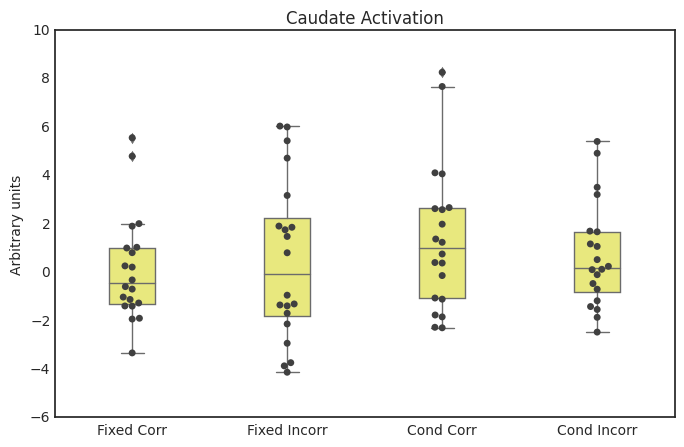

In [16]:
for key in caud_plot:
    print "Mean {0}: ".format(key), np.mean(caud_plot_df['{0}'.format(key)])
    print "STD {0}: ".format(key), np.std(caud_plot_df['{0}'.format(key)])
    print ""

N = 4
ind = np.arange(N)
conditions = ['Fixed Corr', 'Fixed Incorr', 'Cond Corr', 'Cond Incorr']
caud_allsubjs = [caud_plot_df['fixed_corr'], caud_plot_df['fixed_incorr'], 
                 caud_plot_df['cond_corr'], caud_plot_df['cond_incorr']]
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.boxplot(data = caud_allsubjs, color = "#f9f96d", width = 0.3)
ax = sns.swarmplot(data = caud_allsubjs, color='.25')
ax.set_xticklabels(conditions)
ax.set_xticks(ind)
ax.set_ylabel("Arbitrary units")
ax.set_title("Caudate Activation")
plt.show()

## Putamen

Mean fixed_corr:  1.05832521133
STD fixed_corr:  2.29760293647

Mean fixed_incorr:  -0.576718895393
STD fixed_incorr:  2.67859706778

Mean cond_corr:  0.991305777431
STD cond_corr:  2.64565718862

Mean cond_incorr:  -1.17449345086
STD cond_incorr:  2.21593699165



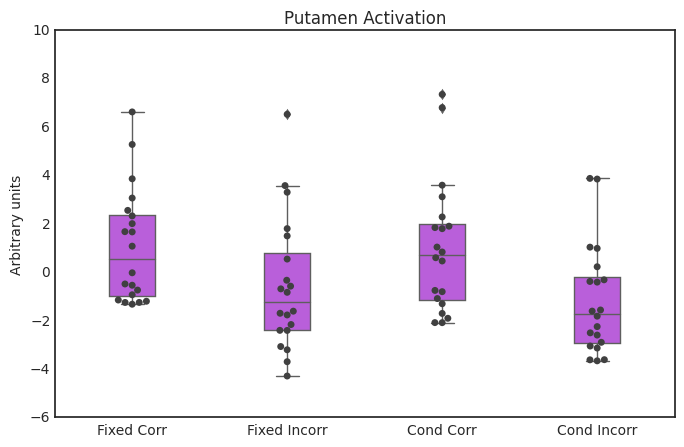

In [18]:
for key in put_plot:
    print "Mean {0}: ".format(key), np.mean(put_plot_df['{0}'.format(key)])
    print "STD {0}: ".format(key), np.std(put_plot_df['{0}'.format(key)])
    print ""

N = 4
ind = np.arange(N)
conditions = ['Fixed Corr', 'Fixed Incorr', 'Cond Corr', 'Cond Incorr']
put_allsubjs = [put_plot_df['fixed_corr'], put_plot_df['fixed_incorr'], 
                put_plot_df['cond_corr'], put_plot_df['cond_incorr']]
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.boxplot(data = put_allsubjs, color = "#c34aef", width = 0.3)
ax = sns.swarmplot(data = put_allsubjs, color='.25')
ax.set_xticklabels(conditions)
ax.set_xticks(ind)
ax.set_ylabel("Arbitrary units")
ax.set_title("Putamen Activation")
plt.show()

# Correlation Scatterplots

In [20]:
all_prop_corr = []

for sub in subs:
    sub_dir = '/home/data/madlab/data/mri/wmaze/scanner_behav/{0}/'.format(sub)
    dir_file = glob(join(sub_dir, '{0}_wmazebl_2015*.txt'.format(sub)))   
    dir_file.sort()    
    
    data_run1 = pd.read_table(dir_file[0])
    data_run1 = data_run1[:-3]
    data_run2 = pd.read_table(dir_file[1])
    data_run2 = data_run2[:-3]
    data_run3 = pd.read_table(dir_file[2])
    data_run3 = data_run3[:-3]
    data_run4 = pd.read_table(dir_file[3])
    data_run4 = data_run4[:-3]
    data_run5 = pd.read_table(dir_file[4])
    data_run5 = data_run5[:-3]
    data_run6 = pd.read_table(dir_file[5])
    data_run6 = data_run6[:-3]
    
    all_runs = [data_run1, data_run2, data_run3, data_run4, data_run5, data_run6]    
    data_set = pd.concat(all_runs)
    
    trialtype = data_set['TrialType'].values
    correct = data_set['Correct'].values 
    
    #removing first trial and shifting down 
    trial_shift = trialtype[:-1] 
    trial_shift = np.insert(trial_shift, 0, -1)
    correct_shift = correct[:-1]
    correct_shift = np.insert(correct_shift, 0, -1)
    
    fixed_corr_after_B = sorted(np.where(((trial_shift=='B') & (correct==1)) & (trialtype!='BL'))[0])    
    fixed_incorr_after_B = sorted(np.where(((trial_shift=='B') & (correct==0)) & (trialtype!='BL'))[0])
    prop_corr = len(fixed_corr_after_B)/float(len(fixed_corr_after_B) + len(fixed_incorr_after_B))
    all_prop_corr.append(prop_corr)
    
all_data_df['prop_corr'] = all_prop_corr

### Get regional activation for all conditional trials

In [24]:
region = ['hp', 'mpfc', 'caud', 'put']
for r in region:
    all_data_df['{0}_all_cond_4'.format(r)] = (all_data_df['lh{0}_cond_corr'.format(r)] 
                                               + all_data_df['rh{0}_cond_corr'.format(r)]
                                               + all_data_df['lh{0}_cond_incorr'.format(r)] 
                                               + all_data_df['rh{0}_cond_incorr'.format(r)])/4.

# Scatterplots -- Brain (Conditional 1) --> Behavior (Fixed 2)

## Hippocampus

COND --> FIXED (-0.15152985089704699, 0.52365137776673509)


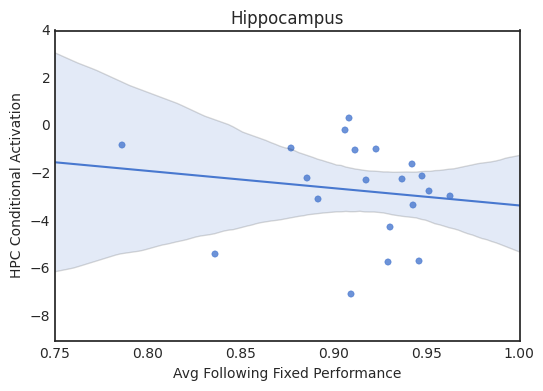

In [30]:
x = all_data_df['prop_corr']
y = all_data_df['hp_all_cond_4']

print 'COND --> FIXED', pearsonr(x,y)
fig, ax = plt.subplots()
ax = sns.regplot(x = 'prop_corr', y = 'hp_all_cond_4', data = all_data_df)
ax.set_ylabel('HPC Conditional Activation')
ax.set_xlabel('Avg Following Fixed Performance')
ax.set_title('Hippocampus')
ax.set_ylim(-9,4)
plt.show()

## mPFC

COND --> FIXED (-0.052800029049799919, 0.82503146616288281)


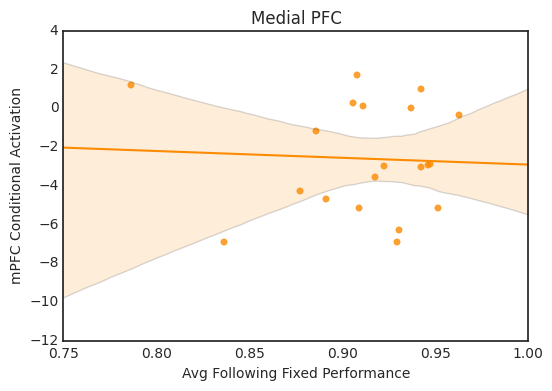

In [29]:
x = all_data_df['prop_corr']
y = all_data_df['mpfc_all_cond_4']

print 'COND --> FIXED', pearsonr(x,y)
fig, ax = plt.subplots()
ax = sns.regplot(x = 'prop_corr', y = 'mpfc_all_cond_4', data = all_data_df, color = "#fc8b02")
ax.set_ylabel('mPFC Conditional Activation')
ax.set_xlabel('Avg Following Fixed Performance')
ax.set_title('Medial PFC')
plt.show()

## Caudate

COND --> FIXED (0.011184148295091267, 0.96267450250039233)


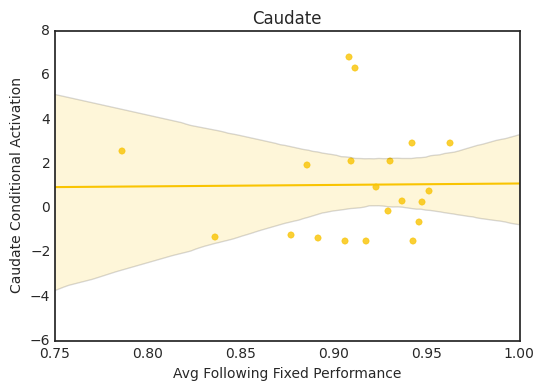

In [26]:
x = all_data_df['prop_corr']
y = all_data_df['caud_all_cond_4']

print 'COND --> FIXED', pearsonr(x,y)
fig, ax = plt.subplots()
ax = sns.regplot(x = 'prop_corr', y = 'caud_all_cond_4', data = all_data_df, color = "#f9c402")
ax.set_ylabel('Caudate Conditional Activation')
ax.set_xlabel('Avg Following Fixed Performance')
ax.set_title('Caudate')
plt.show()

## Putamen

COND --> FIXED (0.21298003369030694, 0.36729468932651432)


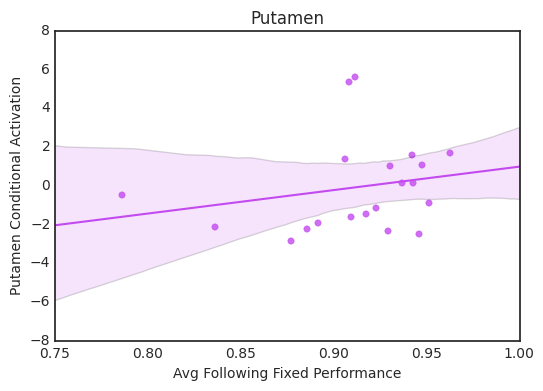

In [27]:
x = all_data_df['prop_corr']
y = all_data_df['put_all_cond_4']

print 'COND --> FIXED', pearsonr(x,y)
fig, ax = plt.subplots()
ax = sns.regplot(x = 'prop_corr', y = 'put_all_cond_4', data = all_data_df, color = "#c34aef")
ax.set_ylabel('Putamen Conditional Activation')
ax.set_xlabel('Avg Following Fixed Performance')
ax.set_title('Putamen')
plt.show()